__Data preparation__
_Writen by Ajay Kumar Tiwari, Benoit Tremblay & Michael Kirk_

In [23]:
# Imports
import scipy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import sunpy.map
import sunpy.sun
from sunpy.map.maputils import all_coordinates_from_map
from sunpy.coordinates import get_horizons_coord
import glob
import hamada_hist_matching

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

# Find sample data
path_to_files = '/home/btremblay/Documents/dir.HelioHackWeek/sampledata/'
filenames_eit_195 = sorted(glob.glob(path_to_files+'eit_l1*'))
filenames_euvi_195_l = sorted(glob.glob(path_to_files+'*eu_L.fts'))
filenames_euvi_195_r = sorted(glob.glob(path_to_files+'*eu_R.fts'))
filenames_test_set = sorted(glob.glob(path_to_files+'EUVI_mask*'))

__SoHO/EIT Data at 195 Å__

In [2]:
# Map objects
nb_files = len(filenames_eit_195)
eit_195_maps = sunpy.map.Map(filenames_eit_195)

# Corrections for EIT (per Michael Kirk)
if eit_195_maps[0].observatory in ['SOHO']:
    new_coords = get_horizons_coord(eit_195_maps[0].observatory.replace(' ', '-'), eit_195_maps[0].date)
    eit_195_maps[0].meta['HGLN_OBS'] = new_coords.lon.to('deg').value
    eit_195_maps[0].meta['HGLT_OBS'] = new_coords.lat.to('deg').value
    eit_195_maps[0].meta['DSUN_OBS'] = new_coords.radius.to('m').value
    eit_195_maps[0].meta.pop('hec_x')
    eit_195_maps[0].meta.pop('hec_y')
    eit_195_maps[0].meta.pop('hec_z')

# Find coordinates and radius
hpc_coords = all_coordinates_from_map(eit_195_maps[0])
r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / eit_195_maps[0].rsun_obs

# Plot disk image
# palette = eit_195_maps[0].cmap
# fig = plt.figure(figsize=(10, 10))
# plt.subplot(projection=eit_195_maps[0])
# eit_195_maps[0].plot(cmap=palette,vmin=-1,vmax=200)
# eit_195_maps[0].draw_limb()
# plt.show()

# Properties
# eit_195_maps[0]

INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


Masking Operation:

In [3]:
# Mask everything outside of the solar disk
mask = ma.masked_greater_equal(r, 1)
ma.set_fill_value(mask, np.nan)
palette = eit_195_maps[0].cmap
eit_195_masked = sunpy.map.Map(eit_195_maps[0].data, eit_195_maps[0].meta, mask=mask.mask)
# Benoit: I think the issue we ran into with the masking is that eit_195_maps[0].data and
#         eit_195_masked.data are the same (it's the data). So we have to manually remove the masked values.
where_disk_eit = np.where(mask.mask == 1)
eit_195_masked.data[where_disk_eit] = np.nan

# Plot disk image
# fig = plt.figure(figsize=(10, 10))
# plt.subplot(projection=eit_195_masked)
# eit_195_masked.plot(cmap=palette,vmin=-1,vmax=200)
# eit_195_masked.draw_limb()
# plt.show()

# Properties
# eit_195_masked

__STEREO EUVI Data at 195 Å__

In [4]:
# Map objects
nb_files = len(filenames_euvi_195_l)
euvi_195_l_maps = sunpy.map.Map(filenames_euvi_195_l)

# Find coordinates and radius
hpc_coords = all_coordinates_from_map(euvi_195_l_maps[0])
r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / euvi_195_l_maps[0].rsun_obs

# Plot Disk Image
# palette = euvi_195_l_maps[0].cmap
# fig = plt.figure(figsize=(10, 10))
# plt.subplot(projection=euvi_195_l_maps[0])
# euvi_195_l_maps[0].plot(cmap=palette,vmin=-1,vmax=5)
# euvi_195_l_maps[0].draw_limb()
# plt.show()

# Properties
# euvi_195_l_maps[0]

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


Masking operation:

In [5]:
# Mask everything outside of the solar disk
mask = ma.masked_greater_equal(r, 1)
ma.set_fill_value(mask, np.nan)
palette = euvi_195_l_maps[0].cmap
euvi_195_l_masked = sunpy.map.Map(euvi_195_l_maps[0].data, euvi_195_l_maps[0].meta, mask=mask.mask)
# Benoit: I think the issue we ran into with the masking is that eit_195_maps[0].data and
#         eit_195_masked.data are the same (it's the data). So we have to manually remove the masked values.
where_disk_euvi_l = np.where(mask.mask == 1)
euvi_195_l_masked.data[where_disk_euvi_l] = np.nan

# Plot disk image
# fig = plt.figure(figsize=(10, 10))
# plt.subplot(projection=euvi_195_l_masked)
# euvi_195_l_masked.plot(cmap=palette,vmin=-1,vmax=5)
# euvi_195_l_masked.draw_limb()
# plt.show()

# Properties
# euvi_195_l_masked

Hamada process:

In [28]:
# Flag
hamada = 1
# Nb. of samples used for process
nb_files = 8

if(hamada ==1):

    # Maps objects
    eit_195_maps = sunpy.map.Map(filenames_eit_195)
    nx_eit, ny_eit = eit_195_maps[0].data.shape

    # Adjust EIT
    # where_disk_eit_195 = np.zeros((nb_files, nx_eit*ny_eit), dtype='bool')
    for i in range(nb_files):

        # Corrections for EIT (per Michael Kirk)
        if eit_195_maps[0].observatory in ['SOHO']:
            new_coords = get_horizons_coord(eit_195_maps[i].observatory.replace(' ', '-'), eit_195_maps[i].date)
            eit_195_maps[i].meta['HGLN_OBS'] = new_coords.lon.to('deg').value
            eit_195_maps[i].meta['HGLT_OBS'] = new_coords.lat.to('deg').value
            eit_195_maps[i].meta['DSUN_OBS'] = new_coords.radius.to('m').value
            eit_195_maps[i].meta.pop('hec_x')
            eit_195_maps[i].meta.pop('hec_y')
            eit_195_maps[i].meta.pop('hec_z')

        # Find coordinates and radius
        hpc_coords = all_coordinates_from_map(eit_195_maps[i])
        r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / eit_195_maps[i].rsun_obs
        # Masking operation
        mask = ma.masked_greater_equal(r, 1)
        ma.set_fill_value(mask, np.nan)
        # Adjust data
        where_disk_eit = np.where(mask.mask == 1)
        eit_195_maps[i].data[where_disk_eit] = np.nan
        # where_disk_eit_195[i, :] = where_disk_eit
        print('EIT: {0}, {1}, {2}, {3}, {4}'.format(i, np.nanmin(eit_195_maps[i].data), np.nanmax(eit_195_maps[i].data),
                                               np.nanmean(eit_195_maps[i].data), np.nanstd(eit_195_maps[i].data)))

    # Adjust EUVI l
    euvi_195_l_maps = sunpy.map.Map(filenames_euvi_195_l)
    nx_euvi, ny_euvi = euvi_195_l_maps[0].data.shape
    # where_disk_euvi_195_l = np.zeros((nb_files, nx_euvi, ny_euvi), dtype='bool')
    for i in range(nb_files):
        # Find coordinates and radius
        hpc_coords = all_coordinates_from_map(euvi_195_l_maps[i])
        r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / euvi_195_l_maps[i].rsun_obs
        # Masking operation
        mask = ma.masked_greater_equal(r, 1)
        ma.set_fill_value(mask, np.nan)
        # Adjust data
        where_disk_euvi = np.where(mask.mask == 1)
        euvi_195_l_maps[i].data[where_disk_euvi] = np.nan
        print('EUVI: {0}, {1}, {2}, {3}, {4}'.format(i, np.nanmin(euvi_195_l_maps[i].data), np.nanmax(euvi_195_l_maps[i].data),
                                                np.nanmean(euvi_195_l_maps[i].data), np.nanstd(euvi_195_l_maps[i].data)))

        # where_disk_euvi_195_l[i, :, :] = where_disk_euvi

    # Adjust EUVI r
    euvi_195_r_maps = sunpy.map.Map(filenames_euvi_195_r)
    # where_disk_euvi_195_r = np.zeros((nb_files, nx_euvi, ny_euvi), dtype='bool')
    for i in range(nb_files):
        # Find coordinates and radius
        hpc_coords = all_coordinates_from_map(euvi_195_r_maps[0])
        r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / euvi_195_r_maps[0].rsun_obs
        # Masking operation
        mask = ma.masked_greater_equal(r, 1)
        ma.set_fill_value(mask, np.nan)
        # Adjust data
        where_disk_euvi = np.where(mask.mask == 1)
        euvi_195_r_maps[i].data[where_disk_euvi] = np.nan
        # where_disk_euvi_195_r[i, :, :] = where_disk_euvi

INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]
EIT: 0, 7.89154329327398, 1504.413661440414, 47.19086677165649, 25.021085106029982
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]
EIT: 1, 9.446041005400428, 3357.789034507337, 47.87220460469255, 33.78364811937331
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]
EIT: 2, 6.701558833828991, 9678.984058591912, 49.49701095488191, 56.75464711983332
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]
EIT: 3, 7.674227303800131, 2406.5634115712387, 50.83222941161248, 57.022948367992065
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]
EIT: 4, 7.322373228034621, 12991.778581532819, 46.056102379285846, 53.3758150837548
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]
EIT: 5, 5.89

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much l

Hamada continued...

In [26]:
# Flag
hamada = 1
# Nb. of samples used for process
nb_files = 8

if(hamada ==1):

    log_eit_195 = np.zeros((nb_files, nx_eit, ny_eit))
    log_euvi_195_l = np.zeros((nb_files, nx_euvi, ny_euvi))
    log_euvi_195_r = np.zeros((nb_files, nx_euvi, ny_euvi))

    for i in range(nb_files):
        log_eit_195[i, :, :] = np.log10(eit_195_maps[i].data)
        log_euvi_195_l[i, :, :] = np.log10(euvi_195_l_maps[i].data**2)
        log_euvi_195_r[i, :, :] = np.log10(euvi_195_r_maps[i].data**2)

    # Normalization
    mean_log_eit_195 = np.nanmean(log_eit_195, axis=(1,2))
    std_log_eit_195 = np.nanstd(log_eit_195, axis=(1,2))
    mean_log_euvi_195_l = np.nanmean(log_euvi_195_l, axis=(1,2))
    std_log_euvi_195_l = np.nanstd(log_euvi_195_l, axis=(1,2))
    mean_log_euvi_195_r = np.nanmean(log_euvi_195_r, axis=(1,2))
    std_log_euvi_195_r = np.nanstd(log_euvi_195_r, axis=(1,2))

    norm_log_eit_195 = np.zeros((nb_files, nx_eit, ny_eit))
    norm_log_euvi_195_l = np.zeros((nb_files, nx_euvi, ny_euvi))
    norm_log_euvi_195_r = np.zeros((nb_files, nx_euvi, ny_euvi))
    for i in range(nb_files):
        print('EIT: {0}, {1}, {2}, {3}'.format(i, np.nanmin(log_eit_195[i, :, :]), np.nanmax(log_eit_195[i, :, :]),
                                               np.nanmean(log_eit_195[i, :, :])))
        print('EUVI: {0}, {1}, {2}, {3}'.format(i, np.nanmin(log_euvi_195_l[i, :, :]), np.nanmax(log_euvi_195_l[i, :, :]),
                                                np.nanmean(log_euvi_195_l[i, :, :])))
        print('EIT: {0}, {1}, {2}'.format(i, mean_log_eit_195[i], std_log_eit_195[i]))
        print('EUVI: {0}, {1}, {2}'.format(i, mean_log_euvi_195_l[i], std_log_euvi_195_l[i]))
        print('EUVI: {0}, {1}, {2}'.format(i, np.nanmean(log_euvi_195_l[i, :, :]), np.nanstd(log_euvi_195_l[i, :, :])))
        norm_log_eit_195[i, :, :] = (log_eit_195[i, :, :] - mean_log_eit_195[i])/std_log_eit_195[i]
        norm_log_euvi_195_l[i, :, :] = (log_euvi_195_l[i, :, :] - mean_log_euvi_195_l[i])/std_log_euvi_195_l[i]
        norm_log_euvi_195_r[i, :, :] = (log_euvi_195_r[i, :, :] - mean_log_euvi_195_r[i])/std_log_euvi_195_r[i]

NameError: name 'nx_eit' is not defined

In [22]:
# Nb. of samples to use for the Hamada process
nb_samples = 8
nb_bins = 400
nb_channels = 3

# Find sample data
path_to_files = '/home/btremblay/Documents/dir.HelioHackWeek/sampledata/'
filenames_eit_0 = sorted(glob.glob(path_to_files+'eit_l1*'))
filenames_euvil_0 = sorted(glob.glob(path_to_files+'*eu_L.fts'))
filenames_eit_1 = sorted(glob.glob(path_to_files+'eit_l1*'))
filenames_euvil_1 = sorted(glob.glob(path_to_files+'*eu_L.fts'))
filenames_eit_2 = sorted(glob.glob(path_to_files+'eit_l1*'))
filenames_euvil_2 = sorted(glob.glob(path_to_files+'*eu_L.fts'))

# Arrays for cdf
cdf_eit = np.zeros((nb_channels, nb_bins-1))
bins_eit = np.zeros((nb_channels, nb_bins))
cdf_euvil = np.zeros((nb_channels, nb_bins-1))
bins_euvil = np.zeros((nb_channels, nb_bins))

# Output
filename_output = 'cumulative_hist.npz'

# Loop over wavelengths
for channel_nb in range(1):
# for channel_nb in range(nb_channels):

    if channel_nb == 0:
        filenames_eit = filenames_eit_0
        filenames_euvil = filenames_euvil_0
    elif channel_nb == 1:
        filenames_eit = filenames_eit_1
        filenames_euvil = filenames_euvil_1
    elif channel_nb == 2:
        filenames_eit = filenames_eit_2
        filenames_euvil = filenames_euvil_2

    # Map objects
    eit_maps = sunpy.map.Map(filenames_eit)  # [channel_nb, :])
    nx_eit, ny_eit = eit_maps[0].data.shape
    # euvil_maps = sunpy.map.Map(filenames_euvil)  # [channel_nb, :])
    euvil_maps = sunpy.map.Map(filenames_euvi_195_l)  # [channel_nb, :])
    nx_euvil, ny_euvil = euvil_maps[0].data.shape

    # Log arrays
    norm_log_eit = np.zeros((nb_samples, nx_eit, ny_eit))
    norm_log_euvil = np.zeros((nb_samples, nx_euvil, ny_euvil))

    # Histograms (of the standardized log intensities)
    hist_eit = np.zeros((nb_samples, nb_bins - 1))
    hist_euvil = np.zeros((nb_samples, nb_bins - 1))

    # Loop over objects
    for file_nb in range(nb_samples):

        if eit_maps[file_nb].observatory in ['SOHO']:
            new_coords = get_horizons_coord(eit_maps[file_nb].observatory.replace(' ', '-'),
                                            eit_maps[file_nb].date)
            eit_maps[0].meta['HGLN_OBS'] = new_coords.lon.to('deg').value
            eit_maps[0].meta['HGLT_OBS'] = new_coords.lat.to('deg').value
            eit_maps[0].meta['DSUN_OBS'] = new_coords.radius.to('m').value
            eit_maps[0].meta.pop('hec_x')
            eit_maps[0].meta.pop('hec_y')
            eit_maps[0].meta.pop('hec_z')

        # Mask everything outside of the solar disk
        # where_mask = mask_outside_disk(eit_maps[file_nb])
        hpc_coords = all_coordinates_from_map(eit_maps[file_nb])
        r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / eit_maps[file_nb].rsun_obs
        # Masking operation
        mask = ma.masked_greater_equal(r, 1)
        ma.set_fill_value(mask, np.nan)
        # Adjust data
        where_mask = np.where(mask.mask == 1)
        eit_maps[file_nb].data[where_mask] = np.nan

        # Mask everything outside of the solar disk
        # where_mask = mask_outside_disk(euvil_maps[file_nb])
        hpc_coords = all_coordinates_from_map(euvil_maps[file_nb])
        r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / euvil_maps[file_nb].rsun_obs
        # Masking operation
        mask = ma.masked_greater_equal(r, 1)
        ma.set_fill_value(mask, np.nan)
        # Adjust data
        where_mask = np.where(mask.mask == 1)
        euvil_maps[file_nb].data[where_mask] = np.nan

        # Benoit: Insert wavelet filter here for EIT and square data

        # Log intensities
        log_eit = np.log10(eit_maps[file_nb].data)
        log_euvil = np.log10(euvil_maps[file_nb].data**2)

        # Normalization
        mean_log_eit = np.nanmean(log_eit)
        std_log_eit = np.nanstd(log_eit)
        mean_log_euvil = np.nanmean(log_euvil)
        std_log_euvil = np.nanstd(log_euvil)
        mean_log_eit2 = np.nanmean(log_eit_195[file_nb, :, :])
        std_log_eit2 = np.nanstd(log_eit_195[file_nb, :, :])
        mean_log_euvil2 = np.nanmean(log_euvi_195_l[file_nb, :, :])
        std_log_euvil2 = np.nanstd(log_euvi_195_l[file_nb, :, :])
        print(log_euvil.shape)
        print(log_euvi_195_l.shape)
        print(log_euvi_195_l[file_nb, :, :].shape)
        print('EIT: {0}, {1}, {2}, {3}'.format(file_nb, np.nanmin(log_eit), np.nanmax(log_eit),
                                               np.nanmean(log_eit)))
        print('EIT: {0}, {1}, {2}, {3}'.format(file_nb, np.nanmin(log_eit_195[file_nb, :, :]), np.nanmax(log_eit_195[file_nb, :, :]),
                                               np.nanmean(log_eit_195[file_nb, :, :])))
        print('EIT: {0}, {1}, {2}'.format(file_nb, mean_log_eit, std_log_eit))
        print('EIT: {0}, {1}, {2}'.format(file_nb, mean_log_eit2, std_log_eit2))
        print('EUVI: {0}'.format(np.nanmax(log_euvil-log_euvi_195_l[file_nb, :, :])))
        print('EUVI: {0}, {1}, {2}, {3}'.format(file_nb, np.nanmin(log_euvil), np.nanmax(log_euvil),
                                                np.nanmean(log_euvil)))
        print('EUVI: {0}, {1}, {2}, {3}'.format(file_nb, np.nanmin(log_euvi_195_l[file_nb, :, :]), np.nanmax(log_euvi_195_l[file_nb, :, :]),
                                                np.nanmean(log_euvi_195_l[file_nb, :, :])))
        print('EUVI: {0}, {1}, {2}'.format(file_nb, mean_log_euvil, std_log_euvil))
        print('EUVI: {0}, {1}, {2}'.format(file_nb, mean_log_euvil2, std_log_euvil2))

INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]
(2048, 2048)
(8, 2048, 2048)
(2048, 2048)
EIT: 0, 0.8971619434136233, 3.17736726855603, 1.635358006380904
EIT: 0, 0.8971619434136233, 3.17736726855603, 1.635358006380904
EIT: 0, 1.635358006380904, 0.17471796396577316
EIT: 0, 1.635358006380904, 0.17471796396577316
EUVI: 0.0
EUVI: 0, -10.600881576538086, 1.375595211982727, -0.2086159735918045
EUVI: 0, -10.600881576538086, 1.375595211982727, -0.20861592767861484
EUVI: 0, -0.2086159735918045, 0.5573341846466064
EUVI: 0, -0.20861592767861484, 0.55733418920665
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]
(2048, 2048)
(8, 2048, 2048)
(2048, 2048)
EIT: 1, 0.9752498265233913, 3.52605340650498, 1.6354175055655524
EIT: 1, 0.9752498265233913, 3.52605340650498, 1.6354175055655524
EIT: 1, 1.6354175055655524, 0.1827032306153773
EIT: 1, 1.6354175055655524, 0.1827032306153773
EUVI: 0.0
EUVI: 1, -10.26259613037

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much l

Hamada continued; let's check our progress...

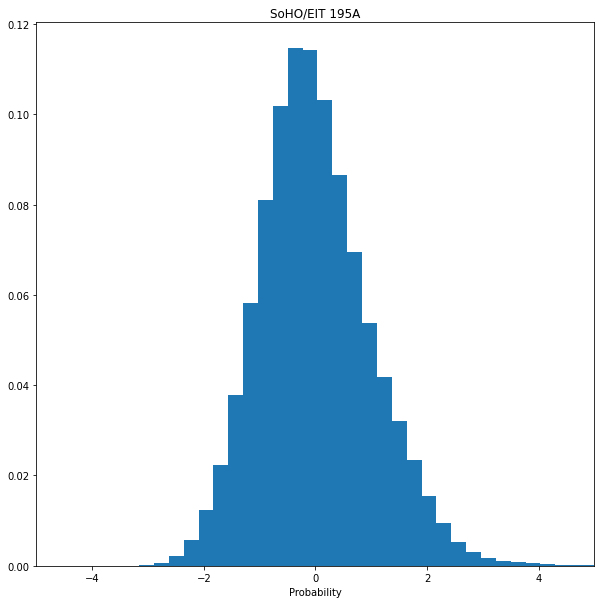

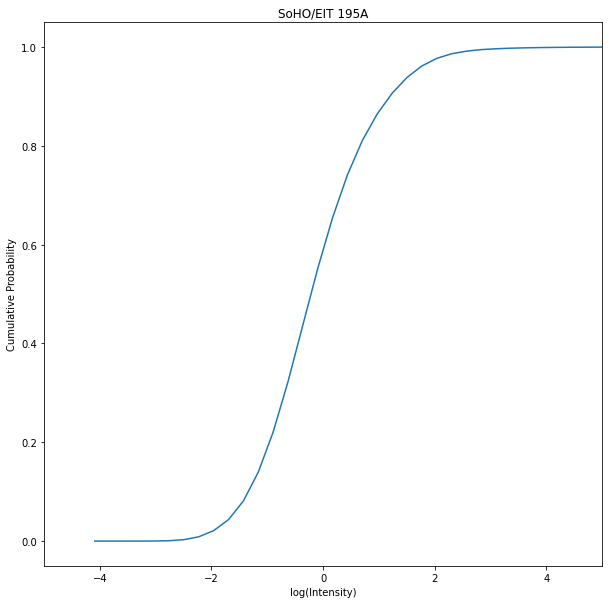

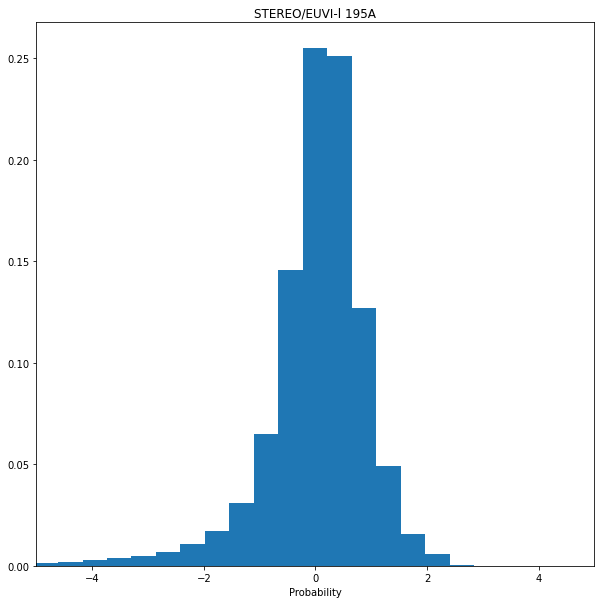

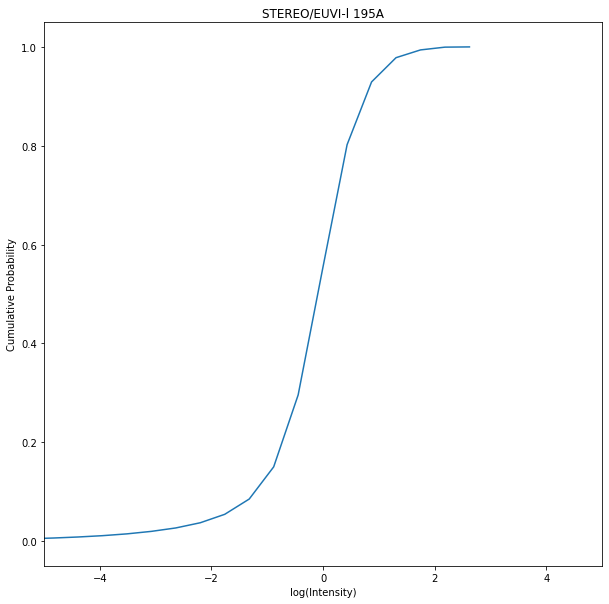

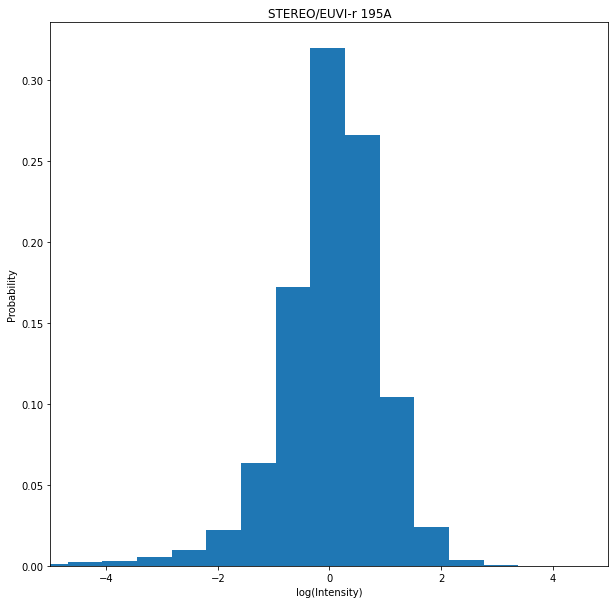

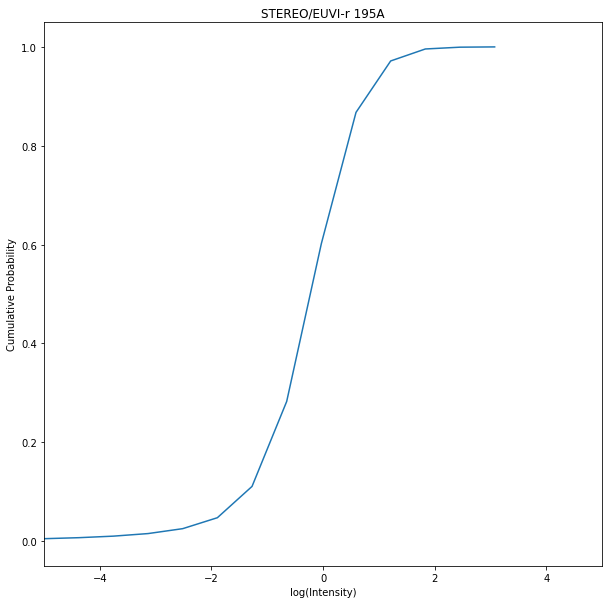

In [34]:
# Histogram: SoHO/EIT
nb = 0
arr_tmp = norm_log_eit_195[nb, :, :]
ii = np.isfinite(arr_tmp)
arr = arr_tmp[ii]
dmin = arr.min()
dmax = arr.max()
num_bins = 50
hist, bins = np.histogram(arr, bins=np.linspace(dmin, dmax, num_bins), density=True)
width = bins[1] - bins[0]
x = (bins[:-1] + bins[1:]) / 2
plt.figure(figsize=(10, 10))
plt.bar(x, hist*width, align='center', width=width, label='Histogram')
plt.xlim(-5., 5)
plt.title('SoHO/EIT 195A')
plt.xlabel('log(Intensity)')
plt.xlabel('Probability')

plt.figure(figsize=(10, 10))
plt.plot(x, np.cumsum(hist*width))
plt.xlim(-5.,5.)
plt.title('SoHO/EIT 195A')
plt.xlabel('log(Intensity)')
plt.ylabel('Cumulative Probability')
plt.show()

# Histogram: STEREO
nb = 0
arr_tmp = norm_log_euvi_195_l[nb, :, :]
ii = np.isfinite(arr_tmp)
arr = arr_tmp[ii]
dmin = arr.min()
dmax = arr.max()
num_bins = 50
hist, bins = np.histogram(arr, bins=np.linspace(dmin, dmax, num_bins), density=True)
width = bins[1] - bins[0]
x = (bins[:-1] + bins[1:]) / 2
plt.figure(figsize=(10, 10))
plt.bar(x, hist*width, align='center', width=width, label='Histogram')
plt.xlim(-5., 5.)
plt.title('STEREO/EUVI-l 195A')
plt.xlabel('log(Intensity)')
plt.xlabel('Probability')

plt.figure(figsize=(10, 10))
plt.plot(x, np.cumsum(hist*width))
plt.xlim(-5.,5.)
plt.title('STEREO/EUVI-l 195A')
plt.xlabel('log(Intensity)')
plt.ylabel('Cumulative Probability')
plt.show()

# Histogram: STEREO
nb = 0
arr_tmp = norm_log_euvi_195_r[nb, :, :]
ii = np.isfinite(arr_tmp)
arr = arr_tmp[ii]
dmin = arr.min()
dmax = arr.max()
num_bins = 50
hist, bins = np.histogram(arr, bins=np.linspace(dmin, dmax, num_bins), density=True)
width = bins[1] - bins[0]
x = (bins[:-1] + bins[1:]) / 2
plt.figure(figsize=(10, 10))
plt.bar(x, hist*width, align='center', width=width, label='Histogram')
plt.xlim(-5., 5.)
plt.title('STEREO/EUVI-r 195A')
plt.xlabel('log(Intensity)')
plt.ylabel('Probability')

plt.figure(figsize=(10, 10))
plt.plot(x, np.cumsum(hist*width))
plt.xlim(-5., 5.)
plt.title('STEREO/EUVI-r 195A')
plt.xlabel('log(Intensity)')
plt.ylabel('Cumulative Probability')
plt.show()

Hamada continued... We loop over all histograms

In [35]:
num_bins = 400
hist_eit_195 = np.zeros((nb_files, num_bins-1))
hist_euvi_195_l = np.zeros((nb_files, num_bins-1))
hist_euvi_195_r = np.zeros((nb_files, num_bins-1))

dmin = np.nanmin(norm_log_eit_195)
dmax = np.nanmax(norm_log_eit_195)
x_eit_195 = np.linspace(dmin, dmax, num_bins)

dmin = np.nanmin(norm_log_euvi_195_l)
dmax = np.nanmax(norm_log_euvi_195_l)
print(dmin)
print(dmax)
x_euvi_195_l = np.linspace(dmin, dmax, num_bins)

dmin = np.nanmin(norm_log_euvi_195_r)
dmax = np.nanmax(norm_log_euvi_195_r)
x_euvi_195_r = np.linspace(dmin, dmax, num_bins)

# Loop over all samples
for i in range(nb_files):
    # EIT
    arr_tmp = norm_log_eit_195[i, :, :]
    ii = np.isfinite(arr_tmp)
    arr = arr_tmp[ii]
    hist, bins = np.histogram(arr, bins=x_eit_195, density=True)
    width = bins[1] - bins[0]
    hist_eit_195[i, :] = hist*width
    # EUVI-l
    arr_tmp = norm_log_euvi_195_l[i, :, :]
    ii = np.isfinite(arr_tmp)
    arr = arr_tmp[ii]
    hist, bins = np.histogram(arr, bins=x_euvi_195_l, density=True)
    width = bins[1] - bins[0]
    hist_euvi_195_l[i, :] = hist*width
    # EUVI-r
    arr_tmp = norm_log_euvi_195_r[i, :, :]
    ii = np.isfinite(arr_tmp)
    arr = arr_tmp[ii]
    hist, bins = np.histogram(arr, bins=x_euvi_195_r, density=True)
    width = bins[1] - bins[0]
    hist_euvi_195_r[i, :] = hist*width

# Average
hist_eit_195 = np.mean(hist_eit_195, axis=0)
hist_euvi_195_l = np.mean(hist_euvi_195_l, axis=0)
hist_euvi_195_r = np.mean(hist_euvi_195_r, axis=0)

'''
plt.figure(figsize=(10, 10))
x = (x_eit_195[:-1] + x_eit_195[1:]) / 2
plt.bar(x, hist_eit_195, align='center', width=width, label='Histogram')
plt.xlim(-5., 5.)
plt.title('SoHO/EIT 195A')
plt.xlabel('log(Intensity)')
plt.xlabel('Probability')
'''

# Cumulative
chist_eit_195 = np.cumsum(hist_eit_195)
chist_euvi_195_l = np.cumsum(hist_euvi_195_l)
chist_euvi_195_r = np.cumsum(hist_euvi_195_r)

-22.086203329662165
3.3991273600059557


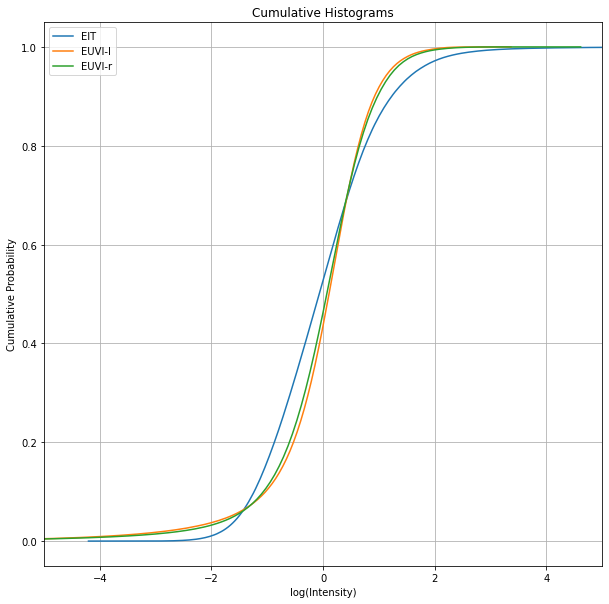

In [36]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
fig, ax = plt.subplots(figsize=(10, 10))
x = (x_eit_195[:-1] + x_eit_195[1:]) / 2
ax.plot(x, chist_eit_195, c=colors[0], label='EIT')
x = (x_euvi_195_l[:-1] + x_euvi_195_l[1:]) / 2
ax.plot(x, chist_euvi_195_l, c=colors[1], label='EUVI-l')
x = (x_euvi_195_r[:-1] + x_euvi_195_r[1:]) / 2
ax.plot(x, chist_euvi_195_r, c=colors[2], label='EUVI-r')
ax.grid(True)
ax.set_xlim(-5., 5.)
ax.set_title('Cumulative Histograms')
ax.set_xlabel('log(Intensity)')
ax.set_ylabel('Cumulative Probability')
ax.legend(loc='best', numpoints=1)
plt.draw()

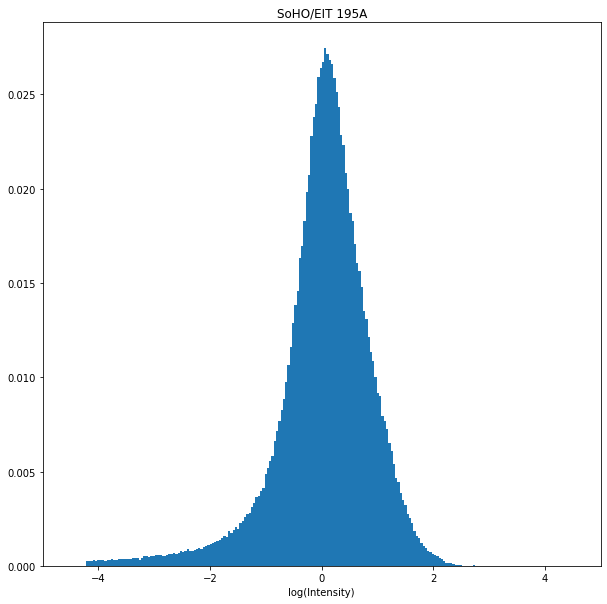

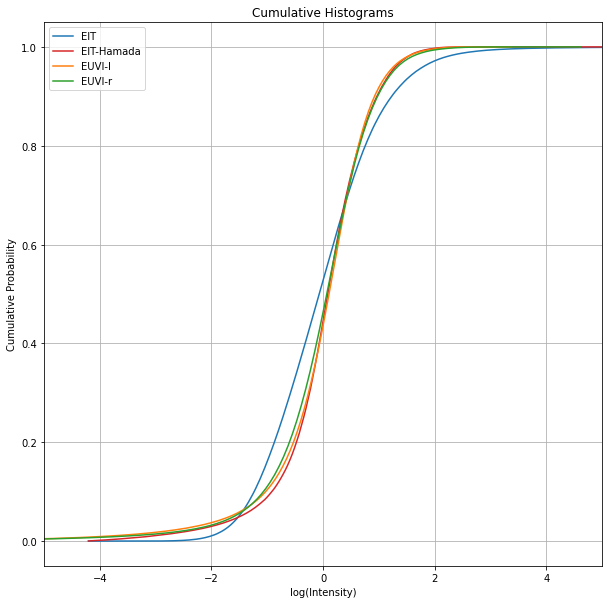

In [37]:
arr_tmp = norm_log_euvi_195_l[0, :, :]
ii = np.isfinite(arr_tmp)
template = arr_tmp[ii]
bin_template = (x_euvi_195_l[:-1] + x_euvi_195_l[1:]) / 2
width_template = x_euvi_195_l[1] - x_euvi_195_l[0]

arr_tmp = norm_log_eit_195[0, :, :]
ii = np.isfinite(arr_tmp)
source = arr_tmp[ii]
bin_source = (x_eit_195[:-1] + x_eit_195[1:]) / 2
width_source = x_euvi_195_l[1] - x_euvi_195_l[0]

# im2 = np.interp(source.flatten(), bin_source.flatten(), chist_eit_195.flatten())
# im3 = np.interp(im2, chist_euvi_195_l.flatten(), bin_template.flatten())
# im3 = np.interp(chist_eit_195.flatten()/width_source, chist_euvi_195_l.flatten()/width_template, bin_template.flatten())
# im3 = np.interp(chist_eit_195.flatten(), chist_euvi_195_l.flatten(), bin_template)
# im3 = np.interp(chist_eit_195.flatten(), chist_euvi_195_l.flatten(), bin_template)

im2 = np.interp(source.flatten(), bin_source.flatten(), chist_eit_195.flatten())
im3 = np.interp(im2, chist_euvi_195_l.flatten(), bin_template.flatten())


hist, bins = np.histogram(im3, bins=x_eit_195, density=True)
width = bins[1] - bins[0]
hist_eit_1952 = hist*width

plt.figure(figsize=(10, 10))
x = (x_eit_195[:-1] + x_eit_195[1:]) / 2
plt.bar(x, hist_eit_1952, align='center', width=width, label='Histogram')
plt.xlim(-5., 5.)
plt.title('SoHO/EIT 195A')
plt.xlabel('log(Intensity)')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
fig, ax = plt.subplots(figsize=(10, 10))
x = (x_eit_195[:-1] + x_eit_195[1:]) / 2
ax.plot(x, chist_eit_195, c=colors[0], label='EIT')
ax.plot(x, np.cumsum(hist_eit_1952), c=colors[3], label='EIT-Hamada')
x = (x_euvi_195_l[:-1] + x_euvi_195_l[1:]) / 2
ax.plot(x, chist_euvi_195_l, c=colors[1], label='EUVI-l')
x = (x_euvi_195_r[:-1] + x_euvi_195_r[1:]) / 2
ax.plot(x, chist_euvi_195_r, c=colors[2], label='EUVI-r')
ax.grid(True)
ax.set_xlim(-5., 5.)
ax.set_title('Cumulative Histograms')
ax.set_xlabel('log(Intensity)')
ax.set_ylabel('Cumulative Probability')
ax.legend(loc='best', numpoints=1)
plt.draw()

In [29]:
import importlib
importlib.reload(hamada_hist_matching)


<module 'hamada_hist_matching' from '/home/btremblay/PycharmProjects/HW20/hamada_hist_matching.py'>

1.1179149901668198e-07
1.1179149901668198e-07


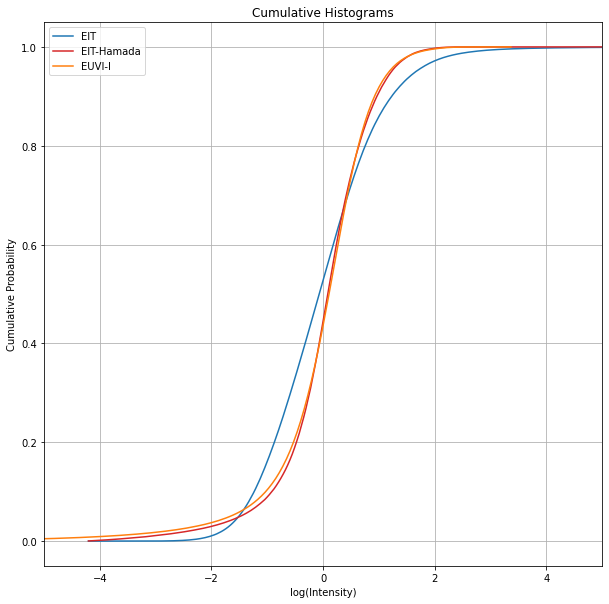

In [51]:
npzfile = np.load('cumulative_hist.npz')
cdf_euvi = npzfile['cdf_euvil']
cdf_euvi = cdf_euvi[0, :]
cdf_eit = npzfile['cdf_eit']
cdf_eit = cdf_eit[0, :]

im2 = np.interp(source.flatten(), bin_source.flatten(), cdf_eit.flatten())
im3 = np.interp(im2, cdf_euvi.flatten(), bin_template.flatten())


# arr_tmp = norm_log_eit_195[0, :, :]
# model2 = hamada_hist_matching.hamada(filename='cumulative_hist.npz')
# arr = model2.hist_matching(arr_tmp, 0)
# log_arr = np.log10(arr)
# mean_log_arr = np.nanmean(log_arr)
# std_log_arr = np.nanstd(log_arr)

# im3 = model2.hist_log_matching(arr_tmp, 0)
# im3 = (log_arr-mean_log_arr)/std_log_arr

hist, bins = np.histogram(im3, bins=x_eit_195, density=True)
width = bins[1] - bins[0]
hist_eit_1952 = hist*width

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
fig, ax = plt.subplots(figsize=(10, 10))
x = (x_eit_195[:-1] + x_eit_195[1:]) / 2
ax.plot(x, chist_eit_195, c=colors[0], label='EIT')
ax.plot(x, np.cumsum(hist_eit_1952), c=colors[3], label='EIT-Hamada')
x = (x_euvi_195_l[:-1] + x_euvi_195_l[1:]) / 2
ax.plot(x, chist_euvi_195_l, c=colors[1], label='EUVI-l')
x = (x_euvi_195_r[:-1] + x_euvi_195_r[1:]) / 2
#ax.plot(x, cdf_euvi, c=colors[2], label='EUVI-r')
ax.grid(True)
ax.set_xlim(-5., 5.)
ax.set_title('Cumulative Histograms')
ax.set_xlabel('log(Intensity)')
ax.set_ylabel('Cumulative Probability')
ax.legend(loc='best', numpoints=1)
plt.draw()

In [24]:
import importlib
importlib.reload(hamada_hist_matching)

<module 'hamada_hist_matching' from '/home/btremblay/PycharmProjects/HW20/hamada_hist_matching.py'>

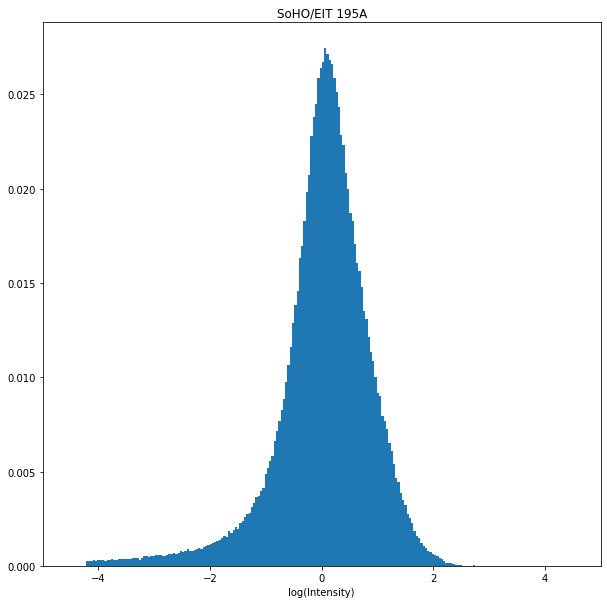

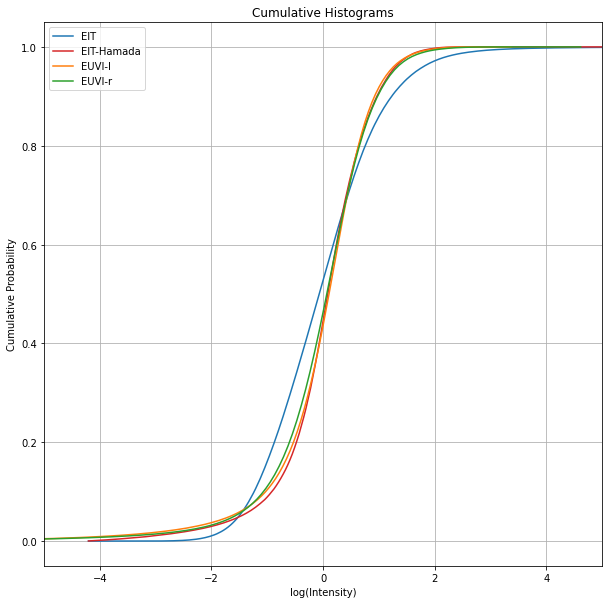

In [56]:
##################

npzfile = np.load('cumulative_hist.npz')
cdf_euvi = npzfile['cdf_euvil']
cdf_euvi = cdf_euvi[0, :]
cdf_eit = npzfile['cdf_eit']
cdf_eit = cdf_eit[0, :]

arr_tmp = norm_log_euvi_195_l[0, :, :]
ii = np.isfinite(arr_tmp)
template = arr_tmp[ii]
bin_template = (x_euvi_195_l[:-1] + x_euvi_195_l[1:]) / 2

arr_tmp = norm_log_eit_195[0, :, :]
ii = np.isfinite(arr_tmp)
source = arr_tmp[ii]
bin_source = (x_eit_195[:-1] + x_eit_195[1:]) / 2

# im2 = np.interp(source.flatten(), bin_source.flatten(), chist_eit_195.flatten())
# im3 = np.interp(im2, chist_euvi_195_l.flatten(), bin_template.flatten())
# im3 = np.interp(chist_eit_195.flatten()/width_source, chist_euvi_195_l.flatten()/width_template, bin_template.flatten())
# im3 = np.interp(chist_eit_195.flatten(), chist_euvi_195_l.flatten(), bin_template)
# im3 = np.interp(chist_eit_195.flatten(), chist_euvi_195_l.flatten(), bin_template)

im2 = np.interp(source.flatten(), bin_source.flatten(), cdf_eit.flatten())
im3 = np.interp(im2, cdf_euvi.flatten(), bin_template.flatten())


hist, bins = np.histogram(im3, bins=x_eit_195, density=True)
width = bins[1] - bins[0]
hist_eit_1952 = hist*width

plt.figure(figsize=(10, 10))
x = (x_eit_195[:-1] + x_eit_195[1:]) / 2
plt.bar(x, hist_eit_1952, align='center', width=width, label='Histogram')
plt.xlim(-5., 5.)
plt.title('SoHO/EIT 195A')
plt.xlabel('log(Intensity)')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
fig, ax = plt.subplots(figsize=(10, 10))
x = (x_eit_195[:-1] + x_eit_195[1:]) / 2
ax.plot(x, chist_eit_195, c=colors[0], label='EIT')
ax.plot(x, np.cumsum(hist_eit_1952), c=colors[3], label='EIT-Hamada')
x = (x_euvi_195_l[:-1] + x_euvi_195_l[1:]) / 2
ax.plot(x, chist_euvi_195_l, c=colors[1], label='EUVI-l')
# x = (x_euvi_195_r[:-1] + x_euvi_195_r[1:]) / 2
# ax.plot(x, chist_euvi_195_r, c=colors[2], label='EUVI-r')
ax.grid(True)
ax.set_xlim(-5., 5.)
ax.set_title('Cumulative Histograms')
ax.set_xlabel('log(Intensity)')
ax.set_ylabel('Cumulative Probability')
ax.legend(loc='best', numpoints=1)
plt.draw()

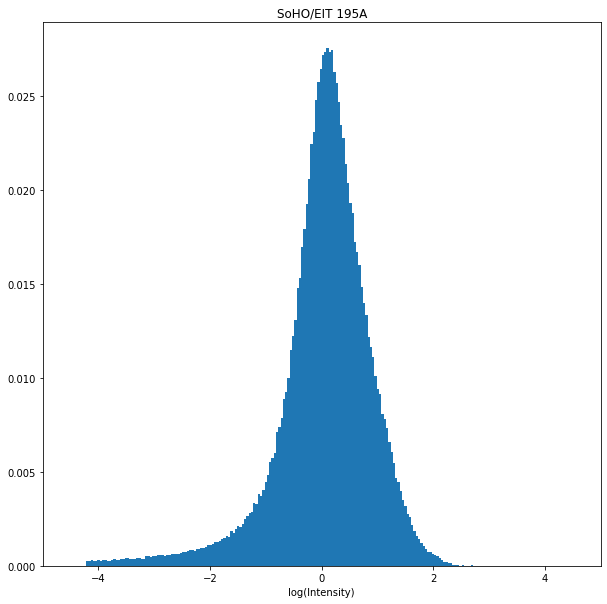

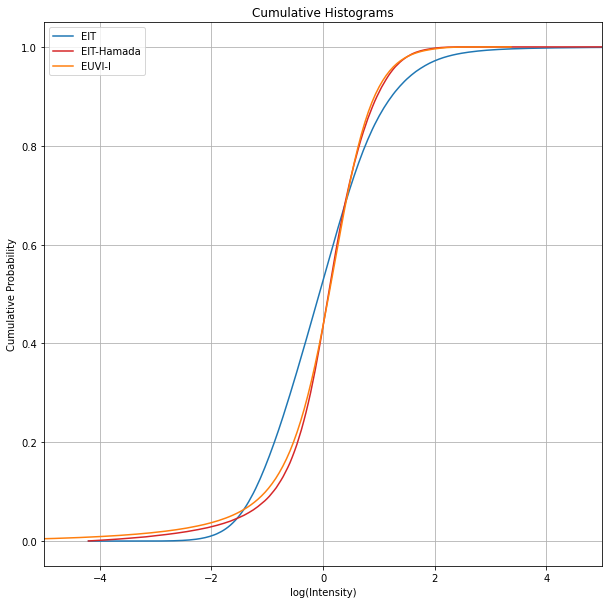

In [30]:

import importlib
importlib.reload(hamada_hist_matching)

arr_tmp = eit_195_maps[0].data
model2 = hamada_hist_matching.hamada(filename='cumulative_hist.npz')
im2 = model2.hist_matching(arr_tmp, 0)
log_eit = np.log10(im2)
mean_log_eit = np.nanmean(log_eit)
std_log_eit = np.nanstd(log_eit)
norm_log_eit = (log_eit - mean_log_eit) / std_log_eit

#arr_tmp = norm_log_eit_195[0, :, :]
#model = hamada_hist_matching.hamada(filename='cumulative_hist.npz')
#im3 = model.hist_log_matching(arr_tmp, 0)

im3=norm_log_eit

npzfile = np.load('cumulative_hist.npz')
cdf_euvil = npzfile['cdf_euvil']
cdf_euvil = cdf_euvil[0, :]
cdf_eit = npzfile['cdf_eit']
cdf_eit = cdf_eit[0, :]
bin_euvi = npzfile['bins_euvil']
x_euvi_195_l = bin_euvi[0, :]
bin_eit = npzfile['bins_eit']
x_eit_195 = bin_eit[0, :]

hist, bins = np.histogram(im3, bins=x_eit_195, density=True)
width = bins[1] - bins[0]
hist_eit_1952 = hist*width

plt.figure(figsize=(10, 10))
x = (x_eit_195[:-1] + x_eit_195[1:]) / 2
plt.bar(x, hist_eit_1952, align='center', width=width, label='Histogram')
plt.xlim(-5., 5.)
plt.title('SoHO/EIT 195A')
plt.xlabel('log(Intensity)')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
fig, ax = plt.subplots(figsize=(10, 10))
x = (x_eit_195[:-1] + x_eit_195[1:]) / 2
ax.plot(x, cdf_eit, c=colors[0], label='EIT')
ax.plot(x, np.cumsum(hist_eit_1952), c=colors[3], label='EIT-Hamada')
x = (x_euvi_195_l[:-1] + x_euvi_195_l[1:]) / 2
ax.plot(x, cdf_euvil, c=colors[1], label='EUVI-l')
#x = (x_euvi_195_r[:-1] + x_euvi_195_r[1:]) / 2
#ax.plot(x, chist_euvi_195_r, c=colors[2], label='EUVI-r')
ax.grid(True)
ax.set_xlim(-5., 5.)
ax.set_title('Cumulative Histograms')
ax.set_xlabel('log(Intensity)')
ax.set_ylabel('Cumulative Probability')
ax.legend(loc='best', numpoints=1)
plt.draw()

In [18]:
for i in range(nb_files):
    euvi_195_l_maps[i].meta['rsun_ref'] = sunpy.sun.constants.radius.to_value(u.m)
    eit_195_maps[i].meta['rsun_ref'] = sunpy.sun.constants.radius.to_value(u.m)
    euvi_195_r_maps[i].meta['rsun_ref'] = sunpy.sun.constants.radius.to_value(u.m)
    print(euvi_195_l_maps[i].observer_coordinate.position_angle(euvi_195_l_maps[i].observer_coordinate).degree)
    print(eit_195_maps[i].observer_coordinate.position_angle(euvi_195_l_maps[i].observer_coordinate).degree)
    print(euvi_195_r_maps[i].observer_coordinate.position_angle(euvi_195_l_maps[i].observer_coordinate).degree)
    print(euvi_195_l_maps[i].observer_coordinate.position_angle(eit_195_maps[i].observer_coordinate).degree)
    print(eit_195_maps[i].observer_coordinate.position_angle(eit_195_maps[i].observer_coordinate).degree)
    print(euvi_195_r_maps[i].observer_coordinate.position_angle(eit_195_maps[i].observer_coordinate).degree)
    print(euvi_195_l_maps[i].observer_coordinate.position_angle(euvi_195_r_maps[i].observer_coordinate).degree)
    print(eit_195_maps[i].observer_coordinate.position_angle(euvi_195_r_maps[i].observer_coordinate).degree)
    print(euvi_195_r_maps[i].observer_coordinate.position_angle(euvi_195_r_maps[i].observer_coordinate).degree)
    print('Separation: {0}, {1}, {2}'.format(euvi_195_l_maps[i].observer_coordinate.separation(euvi_195_l_maps[i].observer_coordinate).degree,
                                             eit_195_maps[i].observer_coordinate.separation(euvi_195_l_maps[i].observer_coordinate).degree,
                                             euvi_195_r_maps[i].observer_coordinate.separation(euvi_195_l_maps[i].observer_coordinate).degree))
    print('Lon: {0}, {1}, {2}'.format(euvi_195_l_maps[i].observer_coordinate.lon.to('degree'),
                                      eit_195_maps[i].observer_coordinate.lon.to('degree'),
                                      euvi_195_r_maps[i].observer_coordinate.lon.to('degree')))
    print('Lon: {0}, {1}, {2}'.format(euvi_195_l_maps[i].observer_coordinate.lon.to('degree')-euvi_195_l_maps[i].observer_coordinate.lon.to('degree'),
                                      eit_195_maps[i].observer_coordinate.lon.to('degree')-euvi_195_l_maps[i].observer_coordinate.lon.to('degree'),
                                      euvi_195_r_maps[i].observer_coordinate.lon.to('degree')-euvi_195_l_maps[i].observer_coordinate.lon.to('degree')))
    print('Lat: {0}, {1}, {2}'.format(euvi_195_l_maps[i].observer_coordinate.lat.to('degree'),
                                      eit_195_maps[i].observer_coordinate.lat.to('degree'),
                                      euvi_195_r_maps[i].observer_coordinate.lat.to('degree')))

for i in range(nb_files):
    print(euvi_195_l_maps[i].observer_coordinate.separation(euvi_195_r_maps[i].observer_coordinate).degree)
    print(eit_195_maps[i].observer_coordinate.separation(euvi_195_r_maps[i].observer_coordinate).degree)
    print(euvi_195_r_maps[i].observer_coordinate.separation(euvi_195_r_maps[i].observer_coordinate).degree)

for i in range(nb_files):
    print(euvi_195_l_maps[i].observer_coordinate.separation(eit_195_maps[i].observer_coordinate).degree)
    print(eit_195_maps[i].observer_coordinate.separation(eit_195_maps[i].observer_coordinate).degree)
    print(euvi_195_r_maps[i].observer_coordinate.separation(eit_195_maps[i].observer_coordinate).degree)

maps = [euvi_195_l_maps[0], eit_195_maps[0], euvi_195_r_maps[0]]
for this_satellite, this_coord in [(m.observatory, m.observer_coordinate) for m in maps]:
    # plt.polar(this_coord.lon.to('rad'), this_coord.radius.to(r_unit), 'o', label=this_satellite)
    print(this_coord.lon.to('deg'))
  #print(eitmaps[m].observer_coordinate.position_angle(stereobmap[m].observer_coordinate).degree)
  #print(stereoamap[m].observer_coordinate.position_angle(eitmaps[m].observer_coordinate).degree)
    #-22d38m15.7997s
    # -0d15m08.5712s
    # 21d06m39.4055s

0.0
277.399286420541
275.6672161393258
97.95116013259648
0.0
275.4347149560388
97.729767314648
96.97843937425988
0.0
Separation: 0.0, 22.572412169308667, 44.01115477212456
Lon: -22.6377221395 deg, -0.2523808776475107 deg, 21.1109459602 deg
Lon: 0.0 deg, 22.38534126185249 deg, 43.7486680997 deg
Lat: 0.131938655932 deg, -2.921698244291308 deg, -5.26686251338 deg
0.0
277.3862125314291
275.64348665444766
97.95040705175364
0.0
275.4104195880033
97.72858642349695
96.96447280180674
0.0
Separation: 0.0, 22.588267699536814, 44.03072255584007
Lon: -22.64741196770001 deg, -0.252750886354022 deg, 21.115792733 deg
Lon: 0.0 deg, 22.394661081345987 deg, 43.76320470070001 deg
Lat: 0.101594391689 deg, -2.951510065547034 deg, -5.28989316774 deg
0.0
277.3731968296482
275.6197159545682
97.94971172339443
0.0
275.38601379321756
97.72733356363835
96.95037012369535
0.0
Separation: 0.0, 22.597238566842325, 44.04341222332078
Lon: -22.657339066900022 deg, -0.253104806437193 deg, 21.1206375531 deg
Lon: 0.0 deg, 2

INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]
-0.22399144446791297
-67.60674453463207
64.42188516396791


/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
/ho

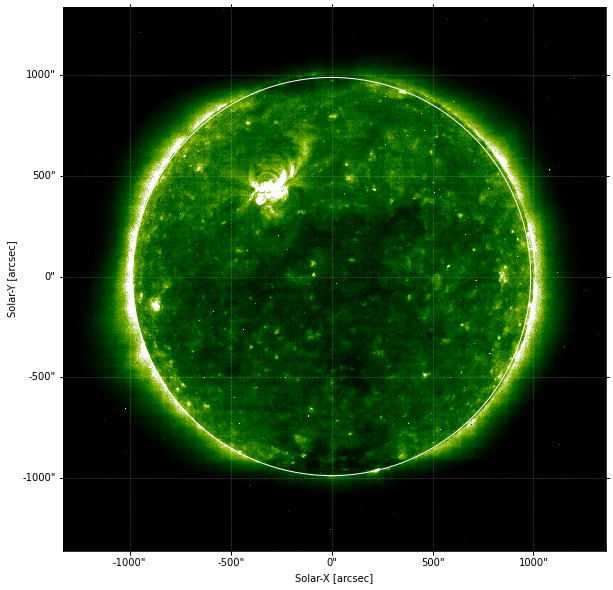

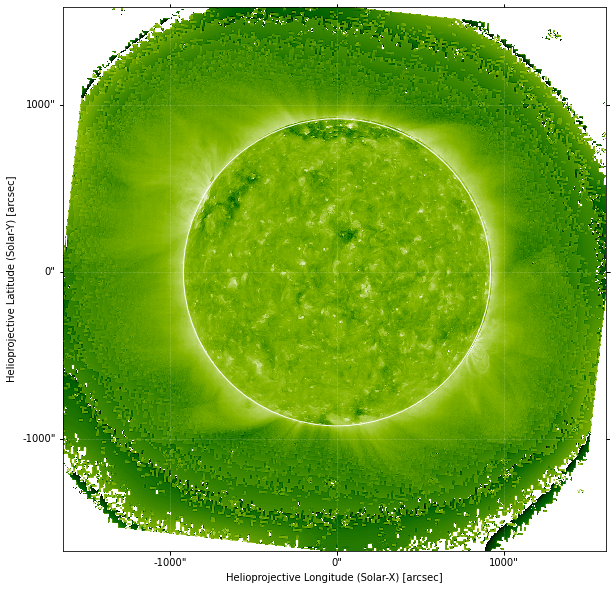

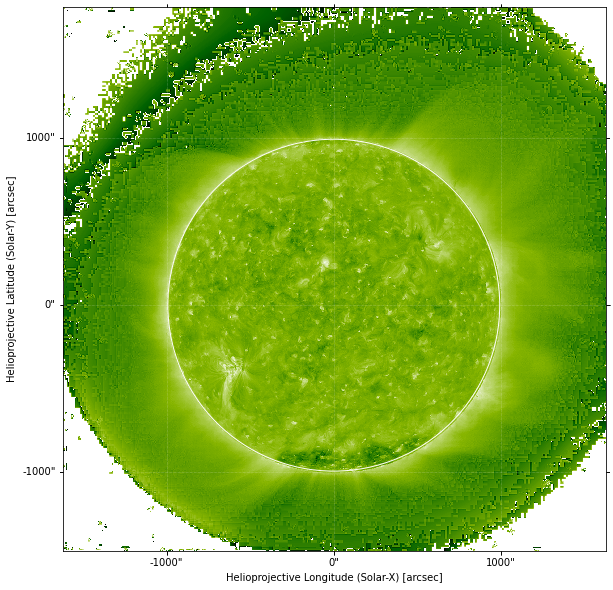

In [44]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import sunpy.map
import sunpy.sun
from sunpy.map.maputils import all_coordinates_from_map
from sunpy.coordinates import get_horizons_coord
import glob
import hamada_hist_matching
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

# Masking function
def mask_outside_disk(inst_map):
    # Find coordinates and radius
    hpc_coords = all_coordinates_from_map(inst_map)
    r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / inst_map.rsun_obs

    # Mask everything outside of the solar disk
    mask = ma.masked_greater_equal(r, 1)
    ma.set_fill_value(mask, np.nan)
    where_disk = np.where(mask.mask == 1)

    return where_disk


def make_hist(norm_log_inst, bins_inst):

    where_mask = np.isfinite(norm_log_inst)
    arr = norm_log_inst[where_mask]
    hist, bins = np.histogram(arr, bins=bins_inst, density=True)
    width = bins[1] - bins[0]

    return hist*width


# Nb. of channels
nb_channels = 3
list_channels = [171, 195, 304]

# Find sample data
path_to_files = '/home/btremblay/Documents/dir.HelioHackWeek/sampledata/'
filenames_eit_0 = sorted(glob.glob(path_to_files+'eit_l1*'))
filenames_euvil_0 = sorted(glob.glob(path_to_files+'*eu_L.fts'))
filenames_euvir_0 = sorted(glob.glob(path_to_files+'*eu_R.fts'))
# Benoit: Needs fixing
filenames_eit_1 = sorted(glob.glob(path_to_files+'eit_l1*'))
filenames_euvil_1 = sorted(glob.glob(path_to_files+'*eu_L.fts'))
filenames_euvir_1 = sorted(glob.glob(path_to_files+'*eu_R.fts'))
# Benoit: Needs fixing
filenames_eit_2 = sorted(glob.glob(path_to_files+'eit_l1*'))
filenames_euvil_2 = sorted(glob.glob(path_to_files+'*eu_L.fts'))
filenames_euvir_2 = sorted(glob.glob(path_to_files+'*eu_R.fts'))
# Nb. of samples to work with
nb_files = len(filenames_euvil_0)

# Hamada class for homogenization
filename = 'cumulative_hist.npz'
hamada_model = hamada_hist_matching.hamada(filename='cumulative_hist.npz')

# Output
output_path = ''

# Loop over all files
file_nb = 7

# Make map objects for one channel
eit_maps = sunpy.map.Map(filenames_eit_0[file_nb])
euvil_maps = sunpy.map.Map(filenames_euvil_0[file_nb])
euvir_maps = sunpy.map.Map(filenames_euvir_0[file_nb])
filename_extract = filenames_eit_0[file_nb].split(path_to_files)
filename_output = output_path + 'composite_' + filename_extract[1]

if eit_maps.observatory in ['SOHO']:
    new_coords = get_horizons_coord(eit_maps.observatory.replace(' ', '-'),
                                    eit_maps.date)
    eit_maps.meta['HGLN_OBS'] = new_coords.lon.to('deg').value
    eit_maps.meta['HGLT_OBS'] = new_coords.lat.to('deg').value
    eit_maps.meta['DSUN_OBS'] = new_coords.radius.to('m').value
    eit_maps.meta.pop('hec_x')
    eit_maps.meta.pop('hec_y')
    eit_maps.meta.pop('hec_z')

# Check positioning of instruments in order to cover full Sun
long_eit = eit_maps.observer_coordinate.lon.to('degree')
print(long_eit.value)
long_euvil = euvil_maps.observer_coordinate.lon.to('degree')-long_eit
print(long_euvil.value)
long_euvir = euvir_maps.observer_coordinate.lon.to('degree')-long_eit
print(long_euvir.value)
if -90 < long_euvil.value < 90 and -90 < long_euvir.value < 90:
    position_condition = 0
elif 90 < long_euvil.value < 180 and long_euvil.value-180 < long_euvir.value < 180:
    position_condition = 0
elif 90 < long_euvir.value < 180 and long_euvir.value-180 < long_euvil.value < 180:
    position_condition = 0
elif -180 < long_euvil.value < -90 and -180 < long_euvir.value < long_euvil.value+180:
    position_condition = 0
elif -180 < long_euvir.value < -90 and -180 < long_euvil.value < long_euvir.value+180:
     position_condition = 0
else:
     position_condition = 1

position_condition = 1

# If positioning is ideal, continue # MODIFY
# if position_condition == 1:

# continue
# for channel_nb in range(1):
channel_nb = 0
# Make map objects
if channel_nb == 1:
    eit_maps = sunpy.map.Map(filenames_eit_1[file_nb])
    euvil_maps = sunpy.map.Map(filenames_euvil_1[file_nb])
    euvir_maps = sunpy.map.Map(filenames_euvir_1[file_nb])
    filename_extract = filenames_eit_1[file_nb].split(path_to_files)
    filename_output = output_path + 'composite_' + filename_extract[1]
elif channel_nb == 2:
    eit_maps = sunpy.map.Map(filenames_eit_2[file_nb])
    euvil_maps = sunpy.map.Map(filenames_euvil_2[file_nb])
    euvir_maps = sunpy.map.Map(filenames_euvir_2[file_nb])
    filename_output = output_path+'composite_' + filenames_eit_2[file_nb]
    filename_extract = filenames_eit_2[file_nb].split(path_to_files)
    filename_output = output_path + 'composite_' + filename_extract[1]

# Adjust SoHO if not already done
if channel_nb > 0 and eit_maps.observatory in ['SOHO']:
    new_coords = get_horizons_coord(eit_maps.observatory.replace(' ', '-'),
                                    eit_maps.date)
    eit_maps.meta['HGLN_OBS'] = new_coords.lon.to('deg').value
    eit_maps.meta['HGLT_OBS'] = new_coords.lat.to('deg').value
    eit_maps.meta['DSUN_OBS'] = new_coords.radius.to('m').value
    eit_maps.meta.pop('hec_x')
    eit_maps.meta.pop('hec_y')
    eit_maps.meta.pop('hec_z')

# eit_maps
# Plot Disk Image
palette = eit_maps.cmap
fig = plt.figure(figsize=(10, 10))
plt.subplot(projection=eit_maps)
eit_maps.plot(cmap=palette, vmin=-1, vmax=200)
eit_maps.draw_limb()
plt.show()
# euvil_maps
palette = euvil_maps.cmap
fig = plt.figure(figsize=(10, 10))
plt.subplot(projection=euvil_maps)
euvil_maps.plot(cmap=palette, vmin=-1, vmax=5)
euvil_maps.draw_limb()
plt.show()
# euvir_maps
palette = euvir_maps.cmap
fig = plt.figure(figsize=(10, 10))
plt.subplot(projection=euvir_maps)
euvir_maps.plot(cmap=palette, vmin=-1, vmax=5)
euvir_maps.draw_limb()
plt.show()

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks 

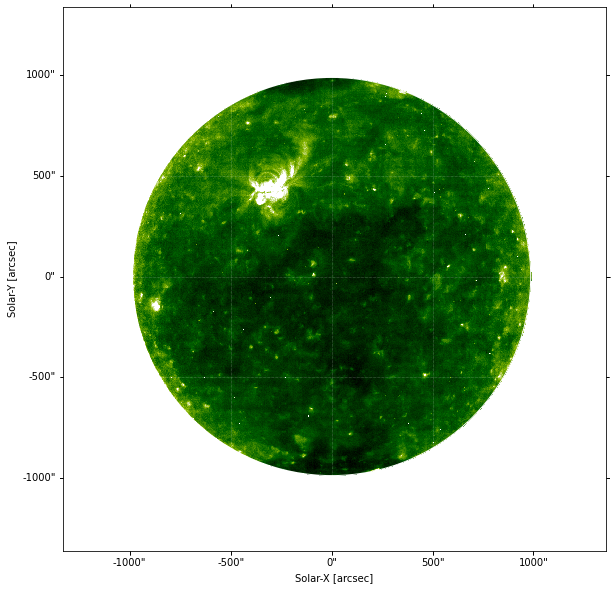

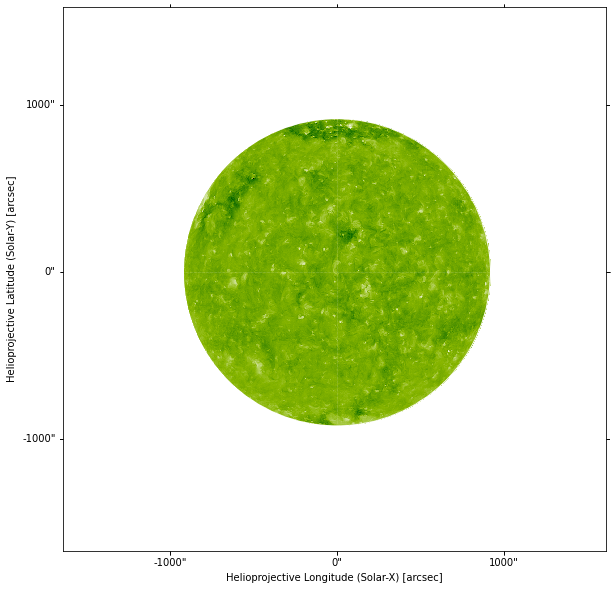

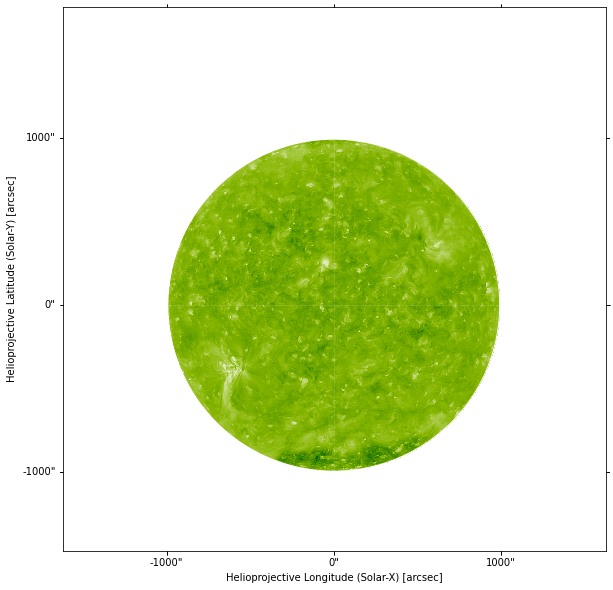

Observatory,STEREO A
Instrument,SECCHI
Detector,EUVI
Measurement,195.0 Angstrom
Wavelength,195.0 Angstrom
Observation Date,2009-12-31 18:00:30
Exposure Time,16.007400 s
Dimension,[2048. 2048.] pix
Coordinate System,helioprojective
Scale,[1.587774 1.587774] arcsec / pix
Reference Pixel,[1020.81 924.882] pix

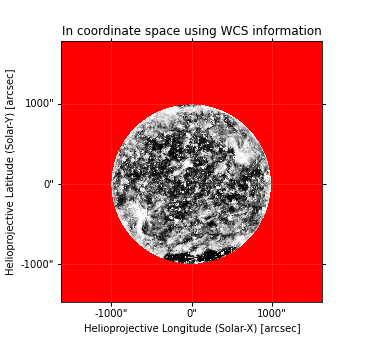
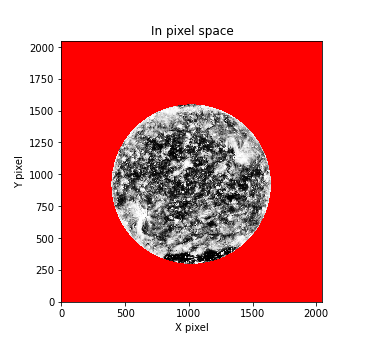
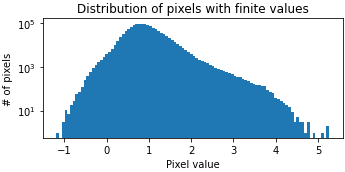

In [45]:
# Mask everything outside the solar disk
where_mask = mask_outside_disk(eit_maps)
eit_maps.data[where_mask] = np.nan
where_mask = mask_outside_disk(euvil_maps)
euvil_maps.data[where_mask] = np.nan
where_mask = mask_outside_disk(euvir_maps)
euvir_maps.data[where_mask] = np.nan
fig = plt.figure(figsize=(10, 10))
plt.subplot(projection=eit_maps)
eit_maps.plot(cmap=palette,vmin=-1,vmax=200)
eit_maps.draw_limb()
plt.show()
eit_maps
fig = plt.figure(figsize=(10, 10))
plt.subplot(projection=euvil_maps)
euvil_maps.plot(cmap=palette)
euvil_maps.draw_limb()
plt.show()
euvil_maps
fig = plt.figure(figsize=(10, 10))
plt.subplot(projection=euvir_maps)
euvir_maps.plot(cmap=palette)
euvir_maps.draw_limb()
plt.show()
euvir_maps

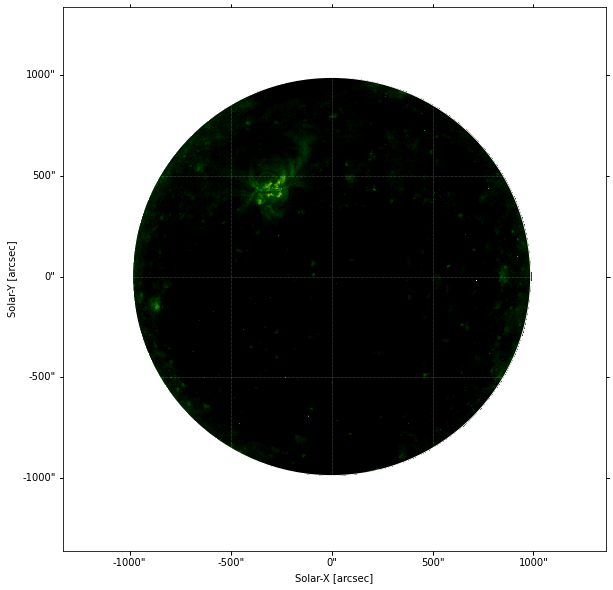

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/sunpy/map/mapbase.py:290: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. c

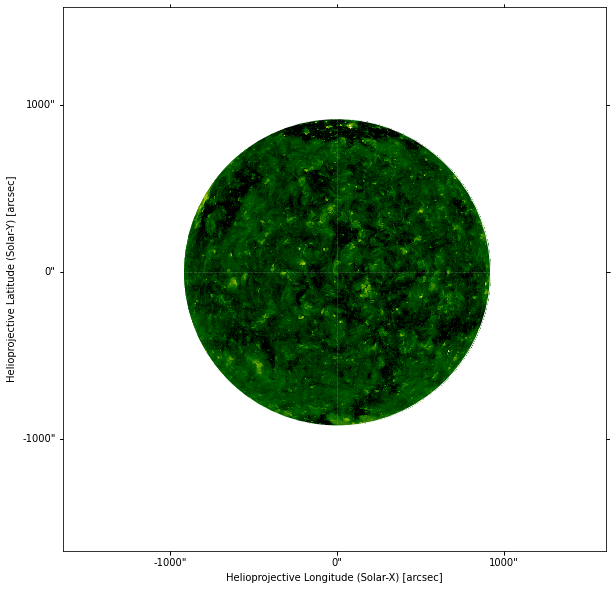

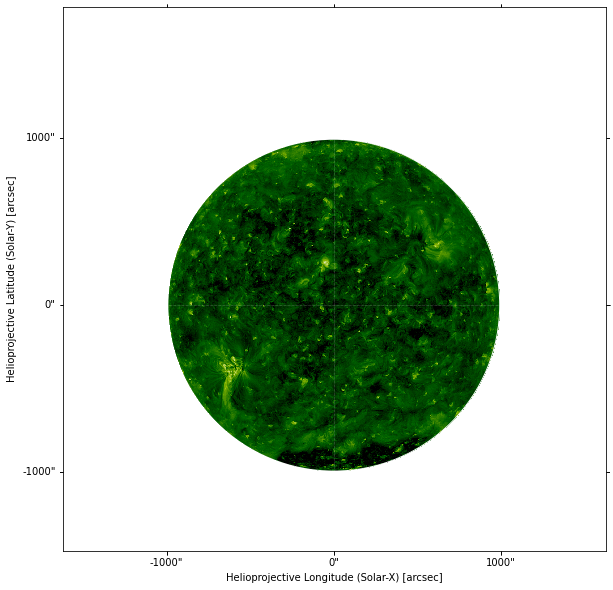

Observatory,STEREO A
Instrument,SECCHI
Detector,EUVI
Measurement,195.0 Angstrom
Wavelength,195.0 Angstrom
Observation Date,2009-12-31 18:00:30
Exposure Time,16.007400 s
Dimension,[2048. 2048.] pix
Coordinate System,helioprojective
Scale,[1.587774 1.587774] arcsec / pix
Reference Pixel,[1020.81 924.882] pix

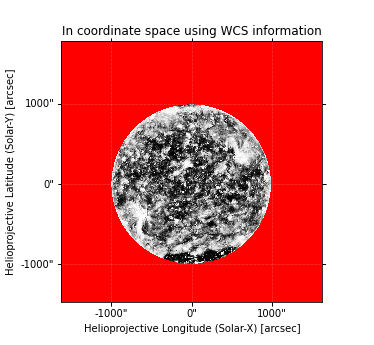
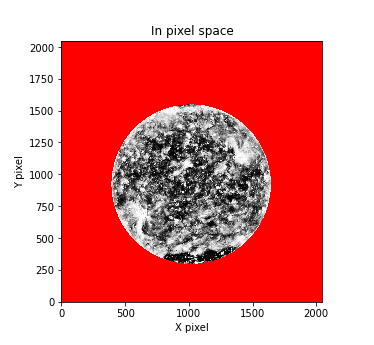
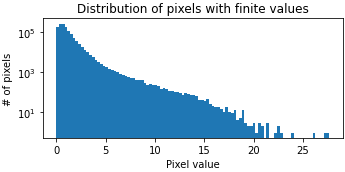

In [46]:
# Wavelet enchancement of the EIT data for improved contrast
# Missing Step ######################
arr_tmp = euvil_maps.data
where_mask = np.isfinite(arr_tmp)
euvil_maps.data[where_mask] = arr_tmp[where_mask]**2
arr_tmp = euvir_maps.data
where_mask = np.isfinite(arr_tmp)
euvir_maps.data[where_mask] = arr_tmp[where_mask]**2
# arr_tmp = eit_maps.data
# eit_maps.data = wavelet_enhancement(arr_tmp)
fig = plt.figure(figsize=(10, 10))
plt.subplot(projection=eit_maps)
eit_maps.plot(cmap=palette)
eit_maps.draw_limb()
plt.show()
eit_maps
fig = plt.figure(figsize=(10, 10))
plt.subplot(projection=euvil_maps)
euvil_maps.plot(cmap=palette)
euvil_maps.draw_limb()
plt.show()
euvil_maps
fig = plt.figure(figsize=(10, 10))
plt.subplot(projection=euvir_maps)
euvir_maps.plot(cmap=palette)
euvir_maps.draw_limb()
plt.show()
euvir_maps

In [47]:
# Homogenization of the EIT data /w respect to EUVI
eit_maps0=eit_maps
arr_tmp = eit_maps.data
where_mask = np.isfinite(arr_tmp)
arr_tmp = hamada_model.hist_matching(arr_tmp, channel_nb)
eit_maps.data[where_mask] = arr_tmp[where_mask]

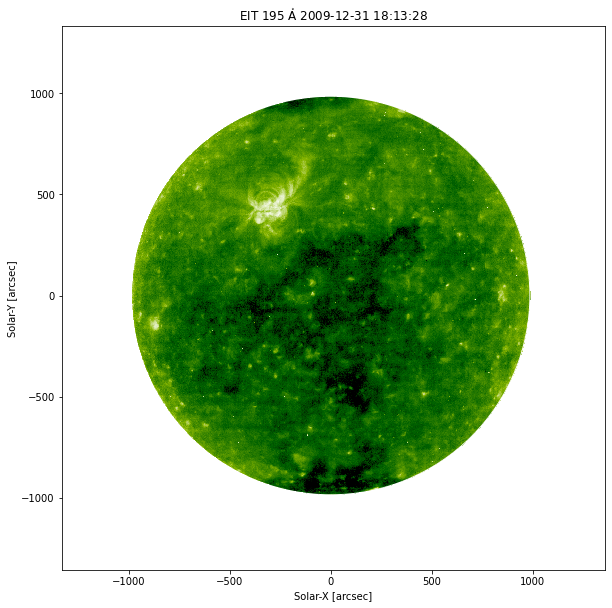

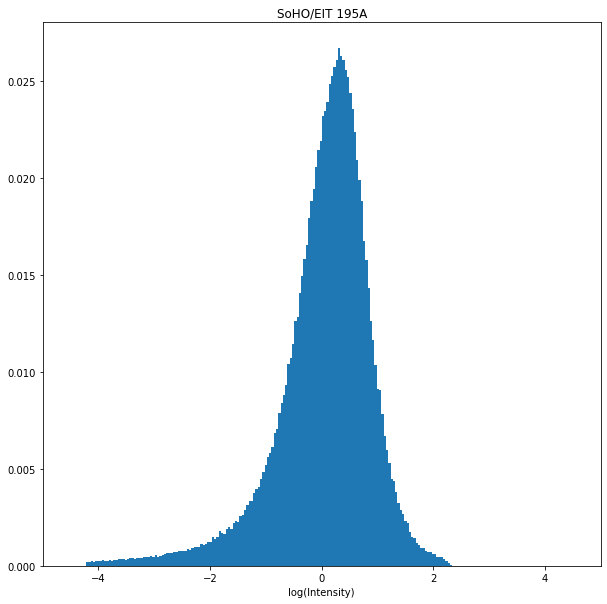

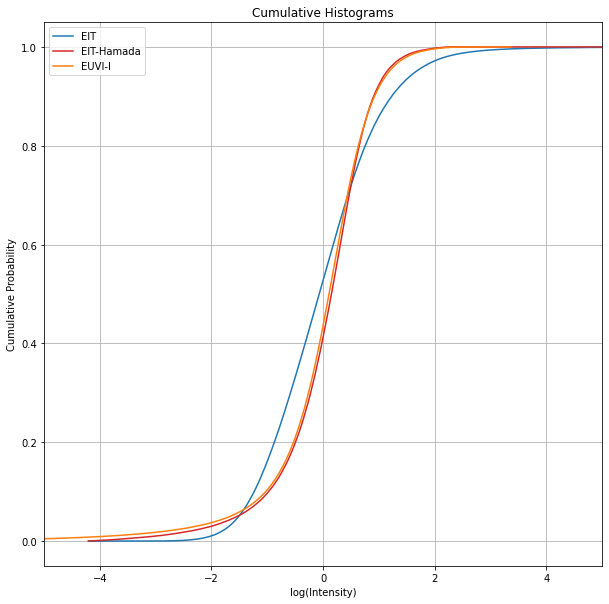

In [48]:
fig = plt.figure(figsize=(10, 10))
plt.subplot()
eit_maps.plot()
eit_maps.draw_limb()
plt.show()

npzfile = np.load('cumulative_hist.npz')
cdf_euvil = npzfile['cdf_euvil']
cdf_euvil = cdf_euvil[0, :]
cdf_eit = npzfile['cdf_eit']
cdf_eit = cdf_eit[0, :]
bin_euvi = npzfile['bins_euvil']
x_euvi_195_l = bin_euvi[0, :]
bin_eit = npzfile['bins_eit']
x_eit_195 = bin_eit[0, :]

log_eit = np.log10(eit_maps.data)
mean_log_eit = np.nanmean(log_eit)
std_log_eit = np.nanstd(log_eit)
norm_log_eit = (log_eit - mean_log_eit) / std_log_eit
im3=norm_log_eit

hist, bins = np.histogram(im3, bins=x_eit_195, density=True)
width = bins[1] - bins[0]
hist_eit_1952 = hist*width

plt.figure(figsize=(10, 10))
x = (x_eit_195[:-1] + x_eit_195[1:]) / 2
plt.bar(x, hist_eit_1952, align='center', width=width, label='Histogram')
plt.xlim(-5., 5.)
plt.title('SoHO/EIT 195A')
plt.xlabel('log(Intensity)')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
fig, ax = plt.subplots(figsize=(10, 10))
x = (x_eit_195[:-1] + x_eit_195[1:]) / 2
ax.plot(x, cdf_eit, c=colors[0], label='EIT')
ax.plot(x, np.cumsum(hist_eit_1952), c=colors[3], label='EIT-Hamada')
x = (x_euvi_195_l[:-1] + x_euvi_195_l[1:]) / 2
ax.plot(x, cdf_euvil, c=colors[1], label='EUVI-l')
ax.grid(True)
ax.set_xlim(-5., 5.)
ax.set_title('Cumulative Histograms')
ax.set_xlabel('log(Intensity)')
ax.set_ylabel('Cumulative Probability')
ax.legend(loc='best', numpoints=1)
plt.draw()

In [49]:
# Combined maps
maps = [eit_maps, euvil_maps, euvir_maps]

# Combined maps
shape_out = (180, 360)  # This is set deliberately low to reduce memory consumption
header = sunpy.map.make_fitswcs_header(shape_out,
                                       SkyCoord(0, 0, unit=u.deg,
                                       frame="heliographic_stonyhurst",
                                       obstime=maps[0].date),
                                       scale=[180 / shape_out[0],
                                              360 / shape_out[1]] * u.deg / u.pix,
                                       wavelength=int(maps[0].meta['wavelnth']) * u.AA,
                                       projection_code="CAR")
out_wcs = WCS(header)
coordinates = tuple(map(sunpy.map.all_coordinates_from_map, maps))
weights = [coord.transform_to("heliocentric").z.value for coord in coordinates]
weights = [(w / np.nanmax(w)) ** 3 for w in weights]
for w in weights:
    w[np.isnan(w)] = 0

array, _ = reproject_and_coadd(maps, out_wcs, shape_out,
                                           input_weights=weights,
                                           reproject_function=reproject_interp,
                                           match_background=True,
                                           background_reference=0)

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


EIT Min=0.004224845283785581, Max=135.81155007733753
EUVIl Min=3.637978807091713e-12, Max=32.13837814331055
EUVIR Min=3.547597771103028e-10, Max=27.631696701049805


/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


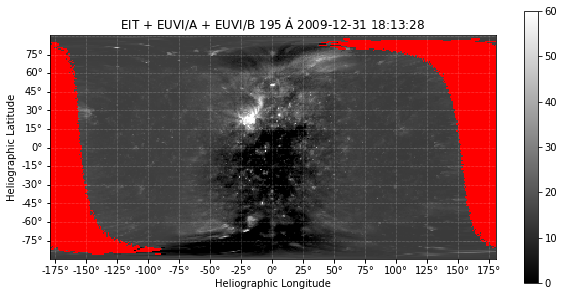

In [53]:
# outmap = sunpy.map.Map((array, header))
# outmap.plot_settings = maps[0].plot_settings
# outmap.nickname = 'AIA + EUVI/A + EUVI/B'

outmap = sunpy.map.Map((array, header))
# outmap.plot_settings = maps[1].plot_settings
outmap.nickname = 'EIT + EUVI/A + EUVI/B'
print('EIT Min={0}, Max={1}'.format(np.nanmin(eit_maps.data), np.nanmax(eit_maps.data)))
print('EUVIl Min={0}, Max={1}'.format(np.nanmin(euvil_maps.data), np.nanmax(euvil_maps.data)))
print('EUVIR Min={0}, Max={1}'.format(np.nanmin(euvir_maps.data), np.nanmax(euvir_maps.data)))

plt.figure(figsize=(10, 5))
ax = plt.subplot(projection=out_wcs)
im = outmap.plot(vmin=0, vmax=60)
# im = outmap.plot()

lon, lat = ax.coords

lon.set_coord_type("longitude")
lon.coord_wrap = 180
lon.set_format_unit(u.deg)
lat.set_coord_type("latitude")
lat.set_format_unit(u.deg)

lon.set_axislabel('Heliographic Longitude', minpad=0.8)
lat.set_axislabel('Heliographic Latitude', minpad=0.9)
lon.set_ticks(spacing=25*u.deg, color='k')
lat.set_ticks(spacing=15*u.deg, color='k')

plt.colorbar(im, ax=ax)

# Reset the view to pixel centers
_ = ax.axis((0, shape_out[1], 0, shape_out[0]))

plt.show()